<a href="https://colab.research.google.com/github/Nourshaolin/Real-Time-Retail-Analytics-and-Product-Recommender/blob/main/RealTime_Retail_Analytics_and_Product_Recommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Real-Time Retail Analytics and Product Recommender
Team members:
* Nour El Moujahid
* Hiba Jebbar
* Ilyass Louzali
* Aya Boumelha

##Milestone 1 (Nour):

Neural Network Workflow (PyTorch): Train deep learning models to predict
purchasing behavior and customer retention based on session logs and historical purchase
data.


###Part 1: Load Kaggle dataset into a Pandas dataframe
Kaggle dataset site: https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset

In [1]:
# Opendatasets is a Python library for downloading datasets from online sources like Kaggle
# Install the library
!pip install opendatasets --upgrade

In [31]:
from kagglehub import KaggleDatasetAdapter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import accuracy_score
import kagglehub
import torch
import torch.nn as nn
import opendatasets as od
import pandas as pd

In [3]:
# Download the dataset
# API TOKEN = {"username":"nourelmoujahid","key":"611189b7ac2a80012221c170415923b6"}
data_url = "https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset"
dataset = od.download(data_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nourelmoujahid
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/online-retail-dataset


In [4]:
# Convert the downloaded dataset into a dataframe
file = 'online-retail-dataset/online_retail_II.xlsx'
df = pd.read_excel(file)

In [27]:
# Pandas dataframe loaded successfully
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


###Part 2: Discover data

Features' Information:

* `InvoiceNo`: Invoice number. If this code starts with the letter 'c', it indicates a cancellation.

* `StockCode`: Product (item) code. A 5-digit integral number uniquely assigned to each distinct product.

* `Description`: Product (item) name.

* `Quantity`: The quantities of each product (item) per transaction.

* `InvoiceDate`: The day and time when a transaction was generated.

* `UnitPrice`: Product price per unit in sterling (Â£).

* `CustomerID`: Customer number. A 5-digit integral number uniquely assigned to each customer.

* `Country`: The name of the country where a customer resides.

In [ ]:
#features' data types
df.dtypes

,0
Invoice,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,datetime64[ns]
Price,float64
Customer ID,float64
Country,object


In [ ]:
# 525461 rows
# 8 columns
df.shape

(525461, 8)

In [ ]:
# Available countries
df["Country"].unique()

array(['United Kingdom', 'France', 'USA', 'Belgium', 'Australia', 'EIRE',
       'Germany', 'Portugal', 'Japan', 'Denmark', 'Nigeria',
       'Netherlands', 'Poland', 'Spain', 'Channel Islands', 'Italy',
       'Cyprus', 'Greece', 'Norway', 'Austria', 'Sweden',
       'United Arab Emirates', 'Finland', 'Switzerland', 'Unspecified',
       'Malta', 'Bahrain', 'RSA', 'Bermuda', 'Hong Kong', 'Singapore',
       'Thailand', 'Israel', 'Lithuania', 'West Indies', 'Lebanon',
       'Korea', 'Brazil', 'Canada', 'Iceland'], dtype=object)

## Part 3: Define The Prediction Task


In [7]:
df.dropna(subset=['Customer ID'], inplace=True)

In [9]:
# Add a 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['Price']
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [13]:
# Group by session (InvoiceNo)
session_data = df.groupby('Invoice').agg({
    'Customer ID': 'first',
    'TotalPrice': 'sum',
    'StockCode': 'nunique',
    'Quantity': 'sum',
    'InvoiceDate': 'first'
}).reset_index()
session_data

,Invoice,Customer ID,TotalPrice,StockCode,Quantity,InvoiceDate
0,489434,13085.0,505.30,8,166,2009-12-01 07:45:00
1,489435,13085.0,145.80,4,60,2009-12-01 07:46:00
2,489436,13078.0,630.33,19,193,2009-12-01 09:06:00
3,489437,15362.0,310.75,23,145,2009-12-01 09:08:00
4,489438,18102.0,2286.24,17,826,2009-12-01 09:24:00
...,...,...,...,...,...,...
23582,C538121,15535.0,-12.75,1,-1,2010-12-09 15:36:00
23583,C538122,14696.0,-1.25,1,-1,2010-12-09 15:38:00
23584,C538123,12605.0,-7.50,3,-4,2010-12-09 15:41:00
23585,C538124,15329.0,-17.70,3,-6,2010-12-09 15:43:00


In [16]:
# Create binary target: 1 if TotalPrice > 0, else 0
session_data['Purchased'] = (session_data['TotalPrice'] > 0).astype(int)
session_data

,Invoice,Customer ID,TotalPrice,StockCode,Quantity,InvoiceDate,Purchased
0,489434,13085.0,505.30,8,166,2009-12-01 07:45:00,1
1,489435,13085.0,145.80,4,60,2009-12-01 07:46:00,1
2,489436,13078.0,630.33,19,193,2009-12-01 09:06:00,1
3,489437,15362.0,310.75,23,145,2009-12-01 09:08:00,1
4,489438,18102.0,2286.24,17,826,2009-12-01 09:24:00,1
...,...,...,...,...,...,...,...
23582,C538121,15535.0,-12.75,1,-1,2010-12-09 15:36:00,0
23583,C538122,14696.0,-1.25,1,-1,2010-12-09 15:38:00,0
23584,C538123,12605.0,-7.50,3,-4,2010-12-09 15:41:00,0
23585,C538124,15329.0,-17.70,3,-6,2010-12-09 15:43:00,0


In [17]:
# Feature columns
X = session_data[['TotalPrice', 'StockCode', 'Quantity']]
y = session_data['Purchased']

In [22]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 0.16498065, -0.45550222, -0.04241839],
       [-0.22685108, -0.65441786, -0.11753924],
       [ 0.30125526,  0.09151578, -0.02328383],
       ...,
       [-0.39393816, -0.70414677, -0.16289523],
       [-0.4050555 , -0.70414677, -0.1643126 ],
       [-0.38788902, -0.80360459, -0.16076917]])

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [28]:
class PurchasePredictor(nn.Module):
    def __init__(self):
        super(PurchasePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(3, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1),
            nn.Sigmoid()  # for binary output
        )

    def forward(self, x):
        return self.model(x)

In [33]:
model = PurchasePredictor()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(10):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

Epoch 1, Loss: 133.1014
Epoch 2, Loss: 50.8495
Epoch 3, Loss: 33.7485
Epoch 4, Loss: 26.1564
Epoch 5, Loss: 21.6548
Epoch 6, Loss: 18.5917
Epoch 7, Loss: 16.1308
Epoch 8, Loss: 14.2878
Epoch 9, Loss: 12.6189
Epoch 10, Loss: 11.4255


In [34]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor).squeeze()
    predicted_classes = (predictions > 0.5).int()
    accuracy = accuracy_score(y_test_tensor.int(), predicted_classes)
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9894


##Milestone 2 (Hiba):
Similarity Search: Use high-dimensional similarity search to identify
customers with comparable behavior, enabling collaborative trends and tailored
suggestions.

# **Data Preparation**





In [ ]:
# Inspect the data structure first
print(f"Dataset shape: {df.shape}")

Dataset shape: (525461, 8)


In [ ]:
print("\nColumn names:")
print(df.columns.tolist())


Column names:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country']


In [ ]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64


In [ ]:
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# Extract date components for time pattern analysis
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek  # 0=Monday, 6=Sunday
df['Hour'] = df['InvoiceDate'].dt.hour

In [ ]:
# Filter out returns (negative quantities) and missing customer IDs
df_clean = df[(df['Quantity'] > 0) & (~df['Customer ID'].isna())]

In [ ]:
print(df_clean[['Quantity', 'Price']].head())
print(df_clean[['Quantity', 'Price']].dtypes)


   Quantity  Price
0        12   6.95
1        12   6.75
2        12   6.75
3        48   2.10
4        24   1.25
Quantity      int64
Price       float64
dtype: object


In [ ]:
df_clean = df[(df['Quantity'] > 0) & (~df['Customer ID'].isna())].copy()
df_clean['TotalAmount'] = df_clean['Quantity'] * df_clean['Price']


In [ ]:
# Set the latest date in the dataset for recency calculation
latest_date = df_clean['InvoiceDate'].max()

In [ ]:
print(f"\nData ranges from {df_clean['InvoiceDate'].min()} to {latest_date}")
print(f"\nAfter cleaning: {df_clean.shape} (rows, columns)")


Data ranges from 2009-12-01 07:45:00 to 2010-12-09 20:01:00

After cleaning: (407695, 14) (rows, columns)


In [ ]:
# Show the cleaned data
df_clean.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Month,Day,DayOfWeek,Hour,TotalAmount
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,12,1,1,7,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,7,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,12,1,1,7,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,12,1,1,7,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,12,1,1,7,30.0



# 1. Feature Set 1: RFM (Recency, Frequency, Monetary) Metrics




Calculate RFM (Recency, Frequency, Monetary) metrics

RFM helps identify a customer's value based on:
- Recency: How recently they purchased (lower days = more engaged)
- Frequency: How often they purchase (higher = more loyal)bold text
- Monetary: How much they spend (higher = more valuable)


In [ ]:
print("\nColumn names:")
print(df.columns.tolist())


Column names:
['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour']


In [ ]:
print(list(df_clean.columns))


['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country', 'Year', 'Month', 'Day', 'DayOfWeek', 'Hour', 'TotalAmount']


In [ ]:
def calculate_rfm_metrics(df, latest_date):
    """
    Calculates RFM metrics for each customer.

    Purpose:
    - Recency identifies which customers are currently engaged
    - Frequency identifies loyal customers
    - Monetary identifies high-value customers
    - Average order value shows spending habits per transaction
    """
    # Group by customer on the cleaned dataset
    customer_group = df.groupby('Customer ID')

    # Recency = Days since last purchase
    recency = (latest_date - customer_group['InvoiceDate'].max()).dt.days.reset_index()
    recency.columns = ['Customer ID', 'Recency']

    # Frequency = Number of unique purchases
    frequency = customer_group['Invoice'].nunique().reset_index()
    frequency.columns = ['Customer ID', 'Frequency']

    # Monetary = Total spent
    monetary = customer_group['TotalAmount'].sum().reset_index()
    monetary.columns = ['Customer ID', 'Monetary']

    # Average order value
    avg_order = customer_group['TotalAmount'].mean().reset_index()
    avg_order.columns = ['Customer ID', 'AvgOrderValue']

    # Merge all metrics
    rfm = recency.merge(frequency, on='Customer ID')\
                 .merge(monetary, on='Customer ID')\
                 .merge(avg_order, on='Customer ID')

    return rfm
# Calculate RFM metrics
rfm_features = calculate_rfm_metrics(df_clean, latest_date)

# Display the RFM metrics for a few customers
print(f"RFM metrics calculated for {len(rfm_features)} customers")
rfm_features.head()

RFM metrics calculated for 4314 customers


,Customer ID,Recency,Frequency,Monetary,AvgOrderValue
0,12346.0,164,11,372.86,11.298788
1,12347.0,2,2,1323.32,18.638310
2,12348.0,73,1,222.16,11.108000
3,12349.0,42,3,2671.14,26.187647
4,12351.0,10,1,300.93,14.330000


# 2.   Feature Set 2: Time Patterns (Day/Hour of Purchases)









In [ ]:
def calculate_time_patterns(df):
    """
    Extracts time-based purchase patterns for each customer.
    """
    # Create day of week dummies (0=Monday, 6=Sunday)
    dow_dummies = pd.get_dummies(df['DayOfWeek'], prefix='DayOfWeek')
    df_with_dow = pd.concat([df[['Customer ID', 'Invoice']], dow_dummies], axis=1)

    # Calculate average day of week distribution per customer
    dow_dist = df_with_dow.groupby('Customer ID')[dow_dummies.columns].mean().reset_index()

    # Group hours into time periods
    df['TimeOfDay'] = pd.cut(df['Hour'],
                             bins=[0, 6, 12, 18, 24],
                             labels=['Night', 'Morning', 'Afternoon', 'Evening'],
                             right=False)

    # Create time of day dummies
    tod_dummies = pd.get_dummies(df['TimeOfDay'], prefix='TimeOfDay')
    df_with_tod = pd.concat([df[['Customer ID', 'Invoice']], tod_dummies], axis=1)

    # Calculate average time of day distribution per customer
    tod_dist = df_with_tod.groupby('Customer ID')[tod_dummies.columns].mean().reset_index()

    # Create month dummies
    month_dummies = pd.get_dummies(df['Month'], prefix='Month')
    df_with_month = pd.concat([df[['Customer ID', 'Invoice']], month_dummies], axis=1)

    # Calculate average monthly distribution per customer
    month_dist = df_with_month.groupby('Customer ID')[month_dummies.columns].mean().reset_index()

    # Combine all time patterns
    time_patterns = dow_dist.merge(tod_dist, on='Customer ID')\
                            .merge(month_dist, on='Customer ID')

    return time_patterns

# Calculate time patterns
time_pattern_features = calculate_time_patterns(df_clean)
# Display the time patterns for a few customers
print(f"Time patterns extracted with {time_pattern_features.shape[1] - 1} features")
time_pattern_features.head()


Time patterns extracted with 23 features


,Customer ID,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,DayOfWeek_5,DayOfWeek_6,TimeOfDay_Night,TimeOfDay_Morning,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
0,12346.0,0.727273,0.151515,0.0,0.030303,0.090909,0.0,0.00000,0.0,0.212121,...,0.151515,0.00000,0.000000,0.575758,0.0,0.0,0.0,0.000000,0.0,0.151515
1,12347.0,0.000000,0.436620,0.0,0.000000,0.000000,0.0,0.56338,0.0,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.563380,0.0,0.436620
2,12348.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,1.0,0.000000,0.0,0.000000
3,12349.0,0.000000,0.009804,0.0,0.990196,0.000000,0.0,0.00000,0.0,0.549020,...,0.000000,0.45098,0.009804,0.000000,0.0,0.0,0.0,0.539216,0.0,0.000000
4,12351.0,1.000000,0.000000,0.0,0.000000,0.000000,0.0,0.00000,0.0,0.000000,...,0.000000,0.00000,0.000000,0.000000,0.0,0.0,0.0,0.000000,1.0,0.000000


#3. Feature Set 3: Product Category Preferences

In [ ]:
def calculate_category_preferences(df):
    """
    Analyzes product category preferences for each customer.
    """
    # Extract product categories (first word of Description as a simple approach)
    df['Category'] = df['Description'].str.split().str[0]

    # Get top 20 categories by frequency
    top_categories = df['Category'].value_counts().nlargest(20).index

    # Filter only rows with top categories
    category_data = df[df['Category'].isin(top_categories)]

    # One-hot encode categories per customer
    category_pivot = pd.crosstab(category_data['Customer ID'], category_data['Category'])

    # Rename columns to have a consistent prefix
    category_pivot.columns = [f'Cat_{col}' for col in category_pivot.columns]

    # Calculate category diversity (number of unique categories purchased)
    cat_diversity = df.groupby('Customer ID')['Category'].nunique().reset_index()
    cat_diversity.columns = ['Customer ID', 'CategoryDiversity']

    # Combine category preferences
    category_prefs = category_pivot.reset_index().merge(cat_diversity, on='Customer ID')

    return category_prefs

# Calculate category preferences
category_preference_features = calculate_category_preferences(df_clean)
# Display the category preferences for a few customers
print(f"Category preferences extracted with {category_preference_features.shape[1] - 1} features")
category_preference_features.head()


Category preferences extracted with 21 features


,Customer ID,Cat_ASSORTED,Cat_BLUE,Cat_CHRISTMAS,Cat_DOOR,Cat_FELTCRAFT,Cat_HEART,Cat_JUMBO,Cat_LUNCH,Cat_PACK,...,Cat_RED,Cat_RETRO,Cat_SET,Cat_SMALL,Cat_STRAWBERRY,Cat_TEA,Cat_VINTAGE,Cat_WHITE,Cat_WOODEN,CategoryDiversity
0,12346.0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,4
1,12347.0,0,3,0,0,0,1,1,0,1,...,3,0,2,1,0,1,0,1,0,47
2,12348.0,0,0,0,0,0,0,0,0,8,...,0,0,3,0,0,0,0,0,0,9
3,12349.0,1,0,0,5,0,1,0,1,1,...,11,2,3,0,2,0,1,1,0,53
4,12351.0,0,1,0,0,0,0,0,0,0,...,2,0,0,0,0,0,0,0,0,16


#4. Feature Set 4: Purchase Variability and Basket Analysis

    Calculates metrics related to purchase patterns and basket characteristics.
    
    Purpose:
    - Measures consistency in shopping behavior
    - Analyzes shopping basket composition
    - Identifies price sensitivity
    

In [ ]:
import numpy as np


In [ ]:
# Calculate metrics related to purchase variability and basket characteristics
# This reveals shopping consistency and basket behaviors

def calculate_purchase_variability(df):
    """
    Calculates metrics related to purchase patterns and basket characteristics.

    Purpose:
    - Measures consistency in shopping behavior
    - Analyzes shopping basket composition
    - Identifies price sensitivity
    """
    # Calculate average basket size (items per transaction)
    basket_items = df.groupby(['Customer ID', 'Invoice'])['Quantity'].sum().reset_index()
    avg_basket = basket_items.groupby('Customer ID')['Quantity'].mean().reset_index()
    avg_basket.columns = ['Customer ID', 'AvgBasketSize']

    # Calculate basket size variability
    basket_var = basket_items.groupby('Customer ID')['Quantity'].std().reset_index()
    basket_var.columns = ['Customer ID', 'BasketSizeVariability']
    basket_var = basket_var.fillna(0)  # Fill NaN for customers with only one purchase

    # Calculate price sensitivity (average unit price paid)
    price_sensitivity = df.groupby('Customer ID')['Price'].mean().reset_index()
    price_sensitivity.columns = ['Customer ID', 'AvgUnitPrice']

    # Calculate purchase intervals
    # First get the first purchase date per invoice for each customer
    invoice_dates = df.groupby(['Customer ID', 'Invoice'])['InvoiceDate'].min().reset_index()
    invoice_dates = invoice_dates.sort_values(['Customer ID', 'InvoiceDate'])

    # Function to calculate intervals between purchases
    def get_purchase_intervals(group):
        if len(group) <= 1:
            return 0, 0  # No interval for single purchase

        # Calculate days between consecutive purchases
        group = group.sort_values('InvoiceDate')
        intervals = group['InvoiceDate'].diff().dt.days.dropna().tolist()

        if not intervals:
            return 0, 0

        return np.mean(intervals), np.std(intervals) if len(intervals) > 1 else 0

    # Apply the function to each customer group
    purchase_intervals = []
    for customer_id, group in invoice_dates.groupby('Customer ID'):
        mean_interval, std_interval = get_purchase_intervals(group)
        purchase_intervals.append({
            'Customer ID': customer_id,
            'PurchaseInterval': mean_interval,
            'PurchaseIntervalStd': std_interval
        })

    purchase_intervals_df = pd.DataFrame(purchase_intervals)

    # Combine all variability metrics
    purchase_variability = avg_basket.merge(basket_var, on='Customer ID', how='left')\
                                    .merge(price_sensitivity, on='Customer ID', how='left')\
                                    .merge(purchase_intervals_df, on='Customer ID', how='left')

    # Fill NaN values
    purchase_variability = purchase_variability.fillna(0)

    return purchase_variability

# Calculate purchase variability metrics
purchase_variability_features = calculate_purchase_variability(df_clean)

# Display the purchase variability for a few customers
print(f"Purchase variability features calculated")
purchase_variability_features.head()

Purchase variability features calculated


,Customer ID,AvgBasketSize,BasketSizeVariability,AvgUnitPrice,PurchaseInterval,PurchaseIntervalStd
0,12346.0,6.363636,4.653444,6.253333,19.2,34.778729
1,12347.0,414.000000,134.350288,2.295070,37.0,0.000000
2,12348.0,373.000000,0.000000,0.719500,0.0,0.000000
3,12349.0,331.000000,286.712399,8.581765,90.0,72.000000
4,12351.0,261.000000,0.000000,2.355238,0.0,0.000000


#5. Feature Set 5: Customer Longevity

    Calculates customer longevity-related metrics.
    
    Purpose:
    - Identifies customer lifecycle stage (new vs. established)
    - Measures customer retention timespan


In [ ]:
def calculate_customer_longevity(df):
    """
    Calculates the number of days between a customer's first and last purchase.
    """
    # Find first and last purchase dates based on InvoiceDate
    first_purchase = df.groupby('Customer ID')['InvoiceDate'].min().reset_index()
    first_purchase.columns = ['Customer ID', 'FirstPurchase']

    last_purchase = df.groupby('Customer ID')['InvoiceDate'].max().reset_index()
    last_purchase.columns = ['Customer ID', 'LastPurchase']

    # Merge and calculate lifespan
    dates = first_purchase.merge(last_purchase, on='Customer ID')
    dates['CustomerLifespan'] = (dates['LastPurchase'] - dates['FirstPurchase']).dt.days

    return dates[['Customer ID', 'CustomerLifespan']]
# Calculate longevity metrics
longevity_features = calculate_customer_longevity(df_clean)

# Display result
print(f"Customer longevity calculated for {len(longevity_features)} customers")
longevity_features.head()


Customer longevity calculated for 4314 customers


,Customer ID,CustomerLifespan
0,12346.0,196
1,12347.0,37
2,12348.0,0
3,12349.0,181
4,12351.0,0


# Combine All Feature Sets and Normalize

In [ ]:
'rfm_features' in locals()


True

In [ ]:
# Combine all the feature sets into customer vectors
# This creates the final representation for similarity search

# Merge all feature sets
customer_features = rfm_features.merge(time_pattern_features, on='Customer ID', how='left')\
                      .merge(category_preference_features, on='Customer ID', how='left')\
                      .merge(purchase_variability_features, on='Customer ID', how='left')\
                      .merge(longevity_features, on='Customer ID', how='left')

# Fill missing values with appropriate defaults
customer_features = customer_features.fillna(0)

# Display the final feature set dimensions
print(f"Created feature vectors for {len(customer_features)} customers with {customer_features.shape[1] - 1} features")
print(f"Feature columns: {customer_features.columns.tolist()}")
customer_features.head()

Created feature vectors for 4314 customers with 54 features
Feature columns: ['Customer ID', 'Recency', 'Frequency', 'Monetary', 'AvgOrderValue', 'DayOfWeek_0', 'DayOfWeek_1', 'DayOfWeek_2', 'DayOfWeek_3', 'DayOfWeek_4', 'DayOfWeek_5', 'DayOfWeek_6', 'TimeOfDay_Night', 'TimeOfDay_Morning', 'TimeOfDay_Afternoon', 'TimeOfDay_Evening', 'Month_1', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_10', 'Month_11', 'Month_12', 'Cat_ASSORTED', 'Cat_BLUE', 'Cat_CHRISTMAS', 'Cat_DOOR', 'Cat_FELTCRAFT', 'Cat_HEART', 'Cat_JUMBO', 'Cat_LUNCH', 'Cat_PACK', 'Cat_PAPER', 'Cat_PINK', 'Cat_RED', 'Cat_RETRO', 'Cat_SET', 'Cat_SMALL', 'Cat_STRAWBERRY', 'Cat_TEA', 'Cat_VINTAGE', 'Cat_WHITE', 'Cat_WOODEN', 'CategoryDiversity', 'AvgBasketSize', 'BasketSizeVariability', 'AvgUnitPrice', 'PurchaseInterval', 'PurchaseIntervalStd', 'CustomerLifespan']


,Customer ID,Recency,Frequency,Monetary,AvgOrderValue,DayOfWeek_0,DayOfWeek_1,DayOfWeek_2,DayOfWeek_3,DayOfWeek_4,...,Cat_VINTAGE,Cat_WHITE,Cat_WOODEN,CategoryDiversity,AvgBasketSize,BasketSizeVariability,AvgUnitPrice,PurchaseInterval,PurchaseIntervalStd,CustomerLifespan
0,12346.0,164,11,372.86,11.298788,0.727273,0.151515,0.0,0.030303,0.090909,...,0.0,0.0,0.0,4.0,6.363636,4.653444,6.253333,19.2,34.778729,196
1,12347.0,2,2,1323.32,18.638310,0.000000,0.436620,0.0,0.000000,0.000000,...,0.0,1.0,0.0,47.0,414.000000,134.350288,2.295070,37.0,0.000000,37
2,12348.0,73,1,222.16,11.108000,1.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,9.0,373.000000,0.000000,0.719500,0.0,0.000000,0
3,12349.0,42,3,2671.14,26.187647,0.000000,0.009804,0.0,0.990196,0.000000,...,1.0,1.0,0.0,53.0,331.000000,286.712399,8.581765,90.0,72.000000,181
4,12351.0,10,1,300.93,14.330000,1.000000,0.000000,0.0,0.000000,0.000000,...,0.0,0.0,0.0,16.0,261.000000,0.000000,2.355238,0.0,0.000000,0


# Normalize Features for Similarity Search

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
# Normalize the features to ensure equal contribution in similarity calculations
# This step is critical for accurate similarity search results

# Separate customer IDs from features
customer_ids = customer_features['Customer ID']
feature_columns = customer_features.columns.drop('Customer ID')

# Apply standardization (mean=0, std=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_features[feature_columns])

# Create a DataFrame with the normalized features
normalized_features = pd.DataFrame(scaled_features, columns=feature_columns)
normalized_features.insert(0, 'CustomerID', customer_ids)

print("Features have been normalized. Ready for similarity search!")
normalized_features.head()

# Optionally save the normalized features for later use
normalized_features.to_csv('customer_feature_vectors.csv', index=False)

Features have been normalized. Ready for similarity search!


# Implementing FAISS for Similarity Search

In [ ]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 47.5 MB/s eta 0:00:00


In [ ]:
# Implement similarity search using FAISS
# This allows efficient finding of similar customers

import faiss

# Extract just the feature columns (excluding CustomerID)
feature_columns = normalized_features.columns.drop('CustomerID')
features_array = normalized_features[feature_columns].values.astype('float32')

# Create a FAISS index
dimension = features_array.shape[1]  # Dimensionality of our feature vectors
index = faiss.IndexFlatL2(dimension)  # L2 distance (Euclidean)
index.add(features_array)  # Add all customer vectors to the index

# Function to find similar customers for a given customer ID
def find_similar_customers(customer_id, k=5):
    """
    Finds k most similar customers to the given customer ID.

    Parameters:
    customer_id: ID of the target customer
    k: Number of similar customers to return

    Returns:
    List of tuples (customer_id, similarity_score)
    """
    # Get the customer index in our arrays
    customer_idx = normalized_features[normalized_features['CustomerID'] == customer_id].index

    if len(customer_idx) == 0:
        return f"Customer ID {customer_id} not found"

    customer_idx = customer_idx[0]

    # Get the feature vector for this customer
    query_vector = features_array[customer_idx].reshape(1, -1)

    # Search for k+1 most similar customers (including self)
    distances, indices = index.search(query_vector, k+1)

    # Remove the query customer from results (it will be the first match)
    similar_indices = indices[0][1:]
    similar_distances = distances[0][1:]

    # Get customer IDs and convert distances to similarity scores
    similar_customers = normalized_features.iloc[similar_indices]['CustomerID'].values
    similarity_scores = 1/(1+similar_distances)  # Convert distance to similarity

    return list(zip(similar_customers, similarity_scores))

# Example: Find similar customers for a specific customer ID
# Replace 17850 with a customer ID from your dataset
sample_customer_id = 17850
similar_customers = find_similar_customers(sample_customer_id, k=5)
print(f"Customers similar to {sample_customer_id}:")
for customer_id, similarity in similar_customers:
    print(f"Customer {customer_id}: Similarity score {similarity:.4f}")

Customers similar to 17850:
Customer 17377.0: Similarity score 0.0003
Customer 13089.0: Similarity score 0.0003
Customer 15311.0: Similarity score 0.0003
Customer 12748.0: Similarity score 0.0003
Customer 15039.0: Similarity score 0.0003


# Testing and Visualization

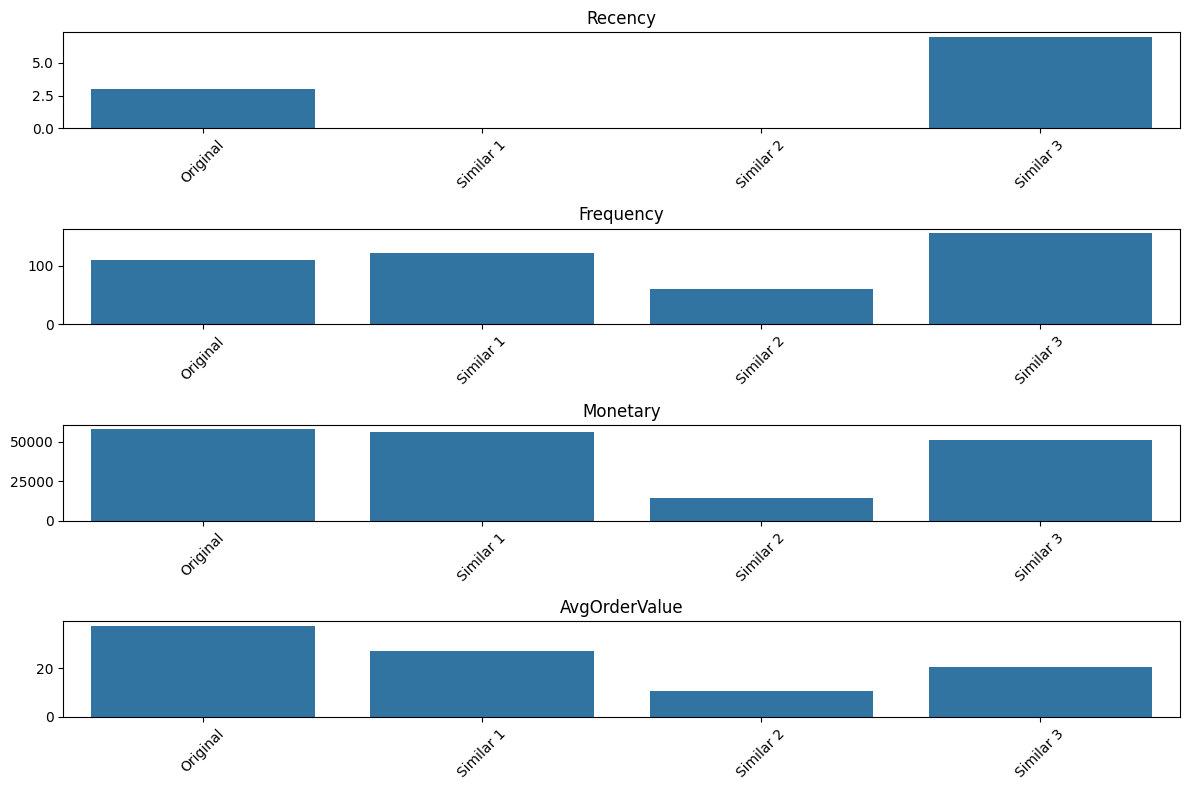

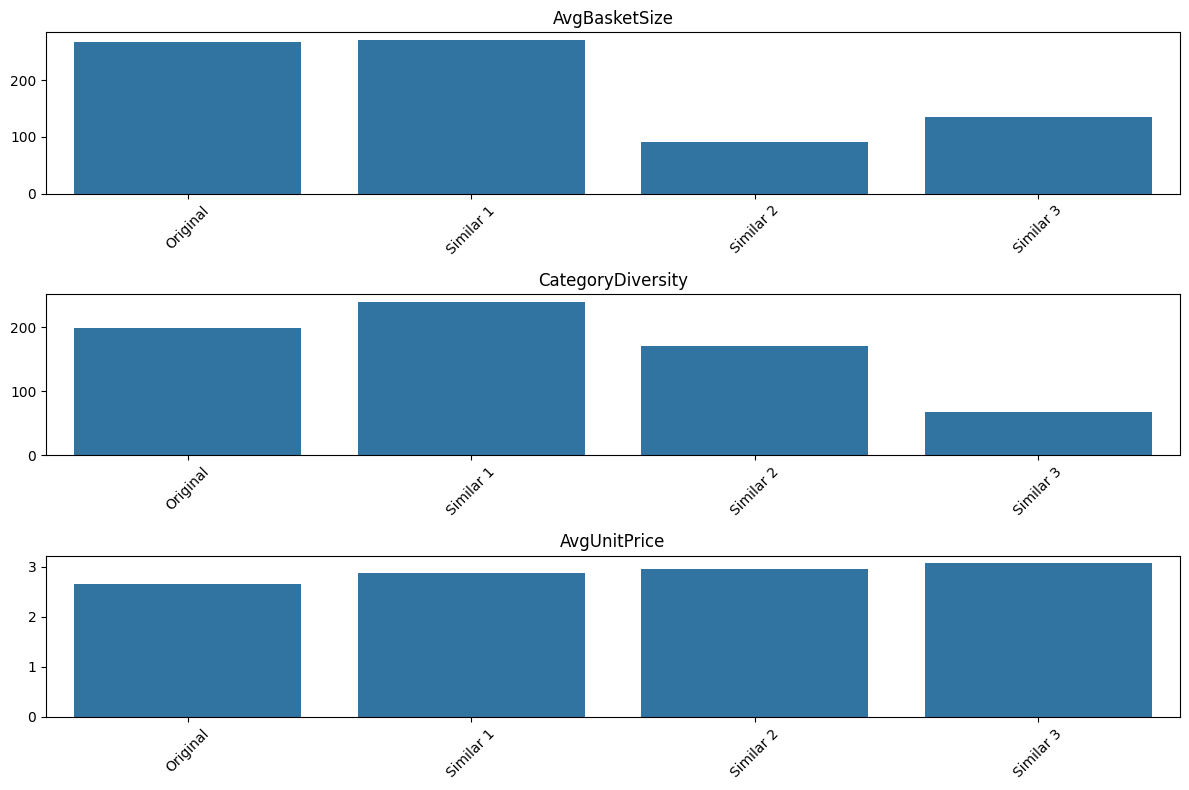

In [ ]:
# Visualize the results to understand customer similarities
# This helps validate that our similarity search is working correctly

import matplotlib.pyplot as plt
import seaborn as sns

# Function to compare original features between a customer and their similar customers
def compare_customers(original_id, similar_ids, features_df, feature_set):
    """
    Visualizes comparisons between a customer and their similar customers
    for a selected set of features.

    Parameters:
    original_id: ID of the target customer
    similar_ids: List of IDs of similar customers
    features_df: DataFrame with all customer features
    feature_set: List of feature names to compare
    """
    # Extract the relevant customer data
    customers_to_compare = [original_id] + list(similar_ids)
    comparison_data = features_df[features_df['Customer ID'].isin(customers_to_compare)]

    # Set up the plot
    plt.figure(figsize=(12, 8))

    # Plot each feature
    for i, feature in enumerate(feature_set):
        plt.subplot(len(feature_set), 1, i+1)

        # Get values for each customer
        values = comparison_data[feature].values
        labels = ["Original"] + [f"Similar {i+1}" for i in range(len(similar_ids))]

        # Create bar chart
        sns.barplot(x=labels, y=values)
        plt.title(feature)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

# Example: Compare RFM metrics between a customer and their similar customers
sample_customer_id = 17850
similar_customers = find_similar_customers(sample_customer_id, k=3)
similar_ids = [cust_id for cust_id, _ in similar_customers]

# Compare RFM metrics
compare_customers(
    sample_customer_id,
    similar_ids,
    customer_features,  # Use non-normalized features for interpretability
    ['Recency', 'Frequency', 'Monetary', 'AvgOrderValue']
)

# Compare basket characteristics
compare_customers(
    sample_customer_id,
    similar_ids,
    customer_features,
    ['AvgBasketSize', 'CategoryDiversity', 'AvgUnitPrice']
)

## Milestone 4 (Aya)
Large-Scale Hypothesis Testing: Conduct hypothesis testing across patient
subgroups to uncover statistically significant health factors. Apply corrections for multiple
testing (e.g., Benjamini-Hochberg).

##Milestone 5 (Louzali)
Recommendation Systems: Develop a recommendation engine to propose
lifestyle changes and follow-up actions based on predicted risks and matched patient
cohorts.